In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime
import re
import matplotlib.pyplot as plt

def clean_tokenize(review_string):
    """
    Clean and tokenize a review string by removing stopwords, punctuation,
    numbers, and empty strings, and then applying lemmatization.
    """    
    lower_string = review_string.lower()
    
    # Combine stopwords and punctuation into one list
    extended_stopwords = set(stopwords.words('english') + list(string.punctuation))

    # Compile a regular expression to match numbers
    number_pattern = re.compile(r'\d+')

    # Tokenize the review string
    tokens = word_tokenize(lower_string)

    # Filter out invalid tokens and convert to lowercase
    valid_tokens = [w for w in tokens if w not in extended_stopwords and not number_pattern.search(w)]

    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize the valid tokens
    clean_tokens = [lemmatizer.lemmatize(token) for token in valid_tokens]

    return clean_tokens

def count_vectorize(tokenized_doc):
    unique_words = set(tokenized_doc)

    word_dict = {word:0 for word in unique_words}

    for word in tokenized_doc:
        word_dict[word] += 1

    return word_dict

def remove_quotes(text):
    # Replace double quotes with nothing
    text = text.replace('"', '')
    # Replace single quotes with nothing
    text = text.replace("'", "")
    return text

def remove_ordinal_suffix(day):
    """Remove ordinal suffix from a day."""
    return re.sub(r'\D', '', day)

def date_converter(date_str):
    """
    Convert a date string to a date object.
    
    Args:
        date_str (str): A date string in the format "DDth Month YYYY".
        
    Returns:
        datetime.date: A date object corresponding to the date string.
    """
    date_list = date_str.split()        
    day = remove_ordinal_suffix(date_list[0])
    month = date_list[1]
    year = date_list[2]

    new_date_str = f"{day} {month} {year}"
    
    return new_date_str

def split_route(route):
    route_clean = str(route).lower().strip()
    if ' to ' in route_clean:
        if ' via ' in route_clean:
            direct_route = route_clean.split(' via ')
            locations = direct_route[0].split(' to ')
        else:
            locations = route_clean.split(' to ')
        origin = locations[0].strip()
        destination = locations[-1].strip()
    else:
        origin = None
        destination = None

    # Extracting the first (departing) and last (arriving) locations
    return origin, destination


old_df = pd.read_csv('data/Airline_review.csv').iloc[:,1:]
df = old_df.copy()
df['review_title']= df['Review_Title'].map(remove_quotes)
df['combined_text'] = df['Review_Title'].map(remove_quotes)+' '+df['Review']
df['tokens'] = df['combined_text'].map(clean_tokenize)
df['clean_review'] = df['tokens'].apply(lambda x: " ".join(x))
df['date_review'] = pd.to_datetime(df['Review Date'].apply(date_converter), format='%d %B %Y')
df['date_flown'] = pd.to_datetime(df['Date Flown'], format='%B %Y')
df['origin'], df['destination'] = zip(*df['Route'].apply(split_route))
df.drop(['Review_Title', 'combined_text', 'Review Date','Date Flown','Aircraft','Review'], axis=1, inplace= True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Airline Name            23171 non-null  object        
 1   Overall_Rating          23171 non-null  object        
 2   Verified                23171 non-null  bool          
 3   Type Of Traveller       19433 non-null  object        
 4   Seat Type               22075 non-null  object        
 5   Route                   19343 non-null  object        
 6   Seat Comfort            19016 non-null  float64       
 7   Cabin Staff Service     18911 non-null  float64       
 8   Food & Beverages        14500 non-null  float64       
 9   Ground Service          18378 non-null  float64       
 10  Inflight Entertainment  10829 non-null  float64       
 11  Wifi & Connectivity     5920 non-null   float64       
 12  Value For Money         22105 non-null  float6

## Descriptive Statistics
- Distribution:`Recommended`, `Verified`
- Countplots:`Overall_Rating`, `Type Of Traveller`, `Seat Type`, `Seat Comfort`, `Cabin Staff Service`, `Food & Beverages`, `Ground Service`, `Inflight Entertainment`, `Wifi & Connectivity`, `Value For Money`.
- Dates: `Review Date`, `Date Flown`
- Other: `Airline Name`, `Aircraft`, `Route`
- Text Analysis: `Review_Title`, `Review`

### Distributions

In [8]:
# Calculate the frequency and percentage of "yes" and "no" recommendation to understand the overall sentiment.
df['Recommended'].value_counts(normalize=True)

Recommended
no     0.66307
yes    0.33693
Name: proportion, dtype: float64

In [9]:
# Same for customer verification
df['Verified'].value_counts(normalize=True)

Verified
True     0.531785
False    0.468215
Name: proportion, dtype: float64

### Countplots

In [11]:
import seaborn as sns

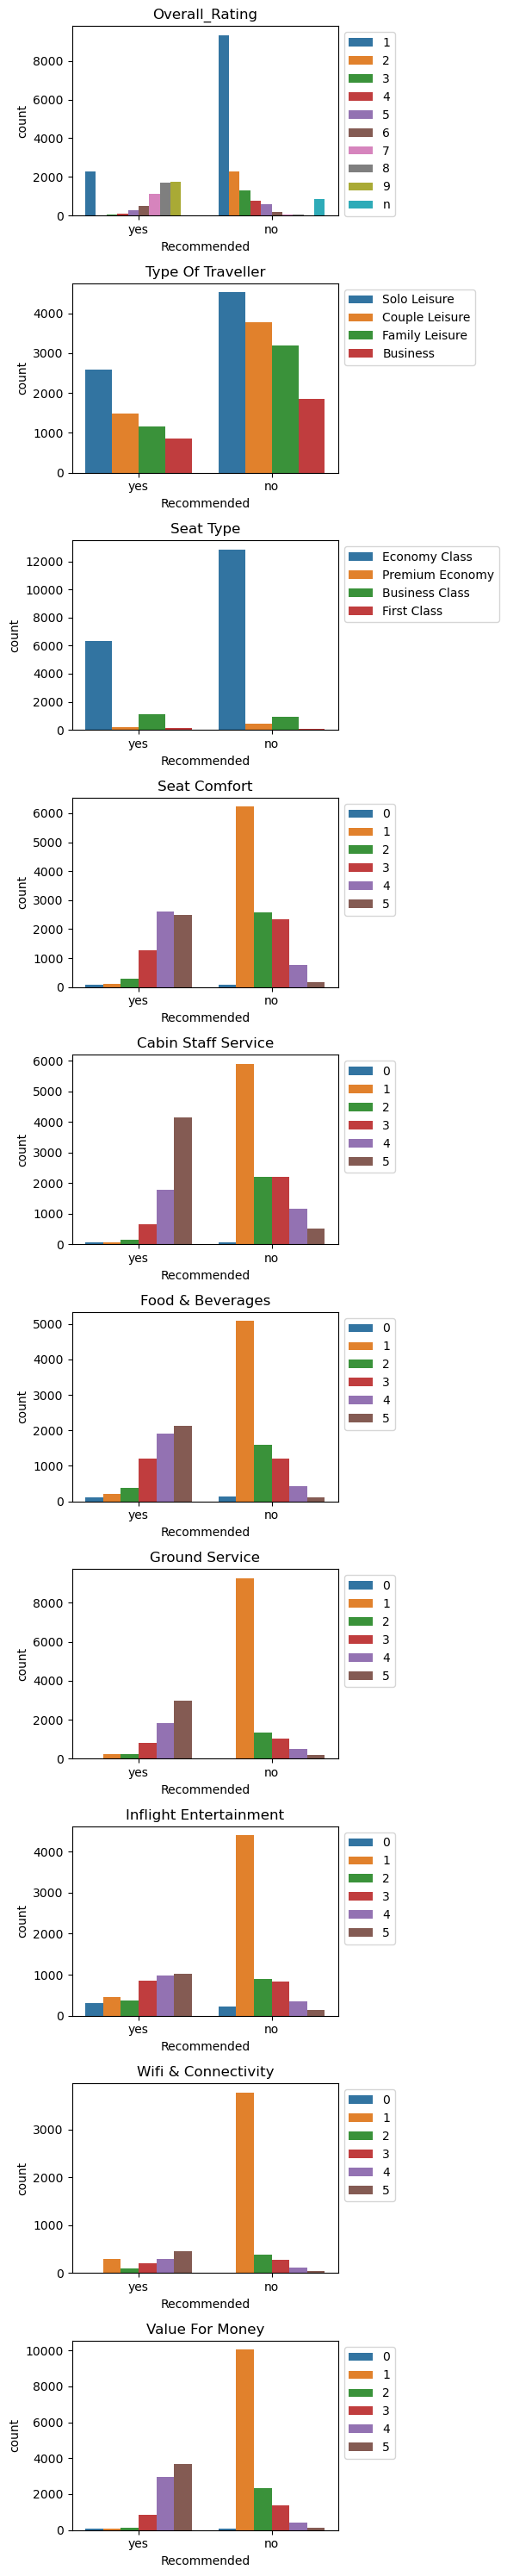

In [12]:
cats = ['Overall_Rating', 'Type Of Traveller', 'Seat Type', 'Seat Comfort',
        'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
        'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money']

default_order = [0, 1, 2, 3, 4, 5]
for column in ['Seat Comfort', 
        'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 
        'Inflight Entertainment','Wifi & Connectivity', 'Value For Money']:
    df[column] = pd.Categorical(df[column], categories=default_order, ordered=True)

df['Overall_Rating'] = pd.Categorical(df['Overall_Rating'], 
                                      categories=['1', '2', '3', '4', '5', '6', '7', '8', '9', 'n'], 
                                      ordered=True)
df['Type Of Traveller'] = pd.Categorical(df['Type Of Traveller'], 
                                      categories=['Solo Leisure', 'Couple Leisure', 'Family Leisure', 'Business'], 
                                      ordered=True)
df['Seat Type'] = pd.Categorical(df['Seat Type'], 
                                      categories=['Economy Class', 'Premium Economy', 'Business Class', 'First Class'], 
                                      ordered=True)


fig, ax = plt.subplots(10, 1, figsize=(6, 30))
for i, j in enumerate(cats):
    sns.countplot(data= df,x= 'Recommended', hue=j,ax=ax[i], dodge=True)
    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].set_title(j)

    n_bars = len(ax[i].patches) // len(df[j].unique())
    
plt.tight_layout()
plt.show()

### Dates

In [ ]:
date_cols = ['date_review', 'date_flown']
for i in date_cols:
    print(df[i].describe())
    print('')


In [ ]:
fig, ax = plt.subplots(2,1,figsize = (8,10), sharex= True)
for i, j in enumerate(['date_review', 'date_flown']):
    sns.histplot(data= df, x=j, ax=ax[i])
    ax[i].set_title(j)
plt.show()

# How can there be review dates before the flight?

In [ ]:
# only 7 review dates before flight dates. not too bad
df.loc[df['date_review']<df['date_flown']]

### Other
Route

In [ ]:
# Airline Name
df['Airline Name'].value_counts()

# Compiler stated 'the maximum amount of reviews being 100 is set as per my scraper code to avoid the use of selenium for scrolling of webpage!'

In [ ]:
df['airline'] = df['Airline Name'].map(lambda x: x.lower())

In [ ]:
# Route
df['Route'].value_counts()

In [ ]:
df['departing_airport'] = df['Route'].apply(lambda x: x.split()[0].lower()

df['Route'][0].split()[0].lower()

In [ ]:
df.iloc[[11311, 13329, 16152, 21208, 21480]]['Route']

In [ ]:
test = df['Route'].str.split(' to ', expand=True)
test.loc[test[2].isna()==False].index

In [ ]:
import pandas as pd

# Assuming df is your DataFrame

# Custom function to handle splitting
def split_route(route):
    parts = str(route).split(' to ')
    if len(parts) == 2:
        return parts
    else:
        # Handle unexpected format, you could return None or a placeholder
        return [None, None]

# Apply custom function and create new columns
split_columns = df['Route'].apply(lambda x: pd.Series(split_route(x)))
df['Departing Airport'] = split_columns[0]
df['Arriving Airport'] = split_columns[1]


### Text Analysis

In [ ]:
df['r_length'] = df['Review'].apply(lambda x: len(x))

In [ ]:
df.loc[df['Recommended']=='no']['r_length'].describe()

In [ ]:
df.loc[df['Recommended']=='yes']['r_length'].describe()

## Missing Values
- Dropping:too many nulls, type of traveler doesn't appear to be any correlation
    - 'Aircraft',
    - 'Type Of Traveller',
    - 'Inflight Entertainment',
    - 'Wifi & Connectivity' 
- Imputing:
    - 'Seat Comfort'
    - 'Cabin Staff Service'
    - 'Food & Beverages'
    - 'Ground Service'
    - 'Value For Money' 
- need to decide:
    - 'Seat Type'
    - 'Route' (impute distance?, does location matter?
    - 'Date Flown'

In [ ]:
,, , 'Inflight Entertainment','Wifi & Connectivity', 

In [ ]:
['Airline Name', lower
 'Overall_Rating', Change to int, impute n to median
 'Verified',
 'Type Of Traveller', drop. there doesn't appear to be a correlation and i don't want to delete 4,000 rows
 'Seat Type',cat ?? Not sure
 
 'Seat Comfort', convert to int, impute median
 'Cabin Staff Service', convert to int, impute median
 'Food & Beverages', convert to int, impute median
 'Ground Service', convert to int, impute median
 'Inflight Entertainment', drop
 'Wifi & Connectivity', drop
 'Value For Money', convert to int, impute median
 'Recommended']